# CIFAR 10 IMAGE RECOGNITION USING A CNN

## Objective

**CIFAR-10** (Canadian Institute for Advanced Research) is a collection of images that are commonly used to train Artifical Intelligence models and more oftenly Neural Networks. This dataset contains 60,000 32x32 color images in 10 different classes.

## Environment Setup & Dataset Loading

The CIFAR-10 dataset is available as a **Python Pickle** for straight use in code. once **unpickled**, we are presented with a python dictionary, containing a key-value pair of **"data"**  pointing to a **numpy array of *uint8***s and another pair, **"labels"**, pointing to a list of 10000 numbers in the **range 0-9**. 

The dataset also contains a file called *batches.meta*, which can provide us with the meaningful names for the numeric labels of the actual data.

---

#### **Downloading The Datasets And Extraction**

In [ ]:
# Downloading CIFAR-10
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Extracting CIFAR-10
!tar -xvf /content/cifar-10-python.tar.gz

> ### **Unpickling The Data**
The dataset is by default seperated into 2 subsets, one with the purpose of training our model and the other for testing the trained model. The training data itself is partitioned into 5 batches, which we combine into one for easier usage.<br/>
Each row of the *X_ sets* contains 3072 columns. Each 1024 subsequent column being the rgb values for the Red, Blue and Green channels, respectively. (hence, 3 * 32 * 32)

> *   *X_train*: A numpy array of 50000, 32 by 32, colored images for training the model.
*   *X_test*: A numpy array of 10000, 32 by 32, colored images for testing purposes.
*   *y_train*: A numpy array of 50000 numbers, in the range of 0-9, for labeling the training data.
*   *y_test*: A numpy array of 10000 numbers, in the range of 0-9, for scoring the test data.






(The **Pickle** module implements an algorithm for turning an arbitrary Python object into a series of bytes. **cPickle** is another implementation of this algorithm.)

In [2]:
from six.moves import cPickle as pickle
import numpy as np
import os

# Helper functions to unpickle cifar-10
def load_pickle(f):
      return  pickle.load(f, encoding='latin1')

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

CIFAR_10_DIR = "./cifar-10-batches-py/"
X_train, y_train, X_test, y_test = load_CIFAR10(CIFAR_10_DIR)

## Preparing & Preprocessing The Data

As with any model, preprocessing the dataset is essential to the learning process, therefore, we are using some of the most common and popular preprocessing techniques that are widely used in the industry.

---


### MetaData

Creating a list of labels with the specific order that the images in the dataset have been labeled.

In [3]:
labels = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]

### Create Validation Set



In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle= True)

### Reshape

As said before, each row (image) contains 3072 elements which contain the Red, Green and Blue channels in every 1024 consequtive elements. By reshaping them we take each pixel's RGB values and put them in a single element as it is expected of an actual image, turning the shape from *3 x 32 x 32* to *32 x 32 x 3*.

In [5]:
X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1).reshape(-1,32,32,3)
X_test = X_test.reshape(-1,3,32,32).transpose(0,2,3,1).reshape(-1,32,32,3)
X_valid = X_valid.reshape(-1,3,32,32).transpose(0,2,3,1).reshape(-1,32,32,3)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)


### Data Augmentation

To expand the dataset and create more data to train the model with, we create a flipped version of each image with the same label, as the direction is often not a deciding factor to classification of the image, hence having more relevant data and a better model overall.

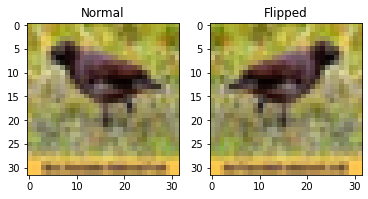

In [9]:
# Preview
preview_image_normal = X_train[4444]
preview_image_flipped = flip_img(X_train[4444])


display_images([(preview_image_normal,"Normal"),(preview_image_flipped,"Flipped")])

In [10]:
# Implementation

X_train, y_train = flip_images_aug(X_train, y_train)

### Data Transformation - Grayscale

We'll continue with transforming the images into grayscale, to reduce the size of each image from 32 * 32 pixels containing 3 values for the RGB color channel into 1 value for the grayscale channel with the equasion below:

```
Grayscale = 0.21 * R + 0.72 * G + 0.07 * B
```
This is done because in most cases the deciding factor of a recognition process is the shapes and the edges and not the color and the process can reduce the input from 32 * 32 * 3 (3072) for each image to only 32 * 32 (1024).

**In our experience this step had a negative impact on the model's accuracy so we'll simply skip this step.**

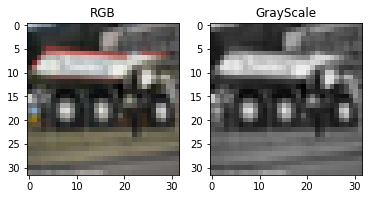

In [11]:
# Grayscale Transformation

# PREVIEW
preview_image = X_train[444]
preview_image_grayscale = grayscale_converter(X_train[444])

display_images([(preview_image,"RGB"),(preview_image_grayscale,"GrayScale")])

In [ ]:
# Implementation

X_train = grayscale_array(X_train)
X_valid = grayscale_array(X_valid)
X_test = grayscale_array(X_test)

### Feature Scaling

We'll proceed with scaling the values for each pixel within the [0,1] range, or essentially dividing each value by 255; which is the range of what our pixels can hold.

In [12]:
X_train = np.true_divide(X_train,255)
X_test = np.true_divide(X_test,255)
X_valid = np.true_divide(X_valid,255)

### One-Hot Encoding The Labels

**One-Hot Encoding** is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. For a classification model such as ours we need to encode each of the 10 labels in our dataset, for the last layer of our model to be able to classify an image within the 10 classes.

In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [14]:
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(80000, 32, 32, 3) (80000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


## Building & Training Model

To start building and training our model, we'll import the required libraries. We'll be using the **Keras** API which uses Google's **Tensorflow** under the hood.

In [15]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.constraints import max_norm

We used three structures for our model going from simple to complex.
As expected the more complex model had an overall better result than the simple one.

#### Structure 1
Our first model, contains 3 Convolutional layers each of them being followed by a 2x2 MaxPooling layer and DropOut layer.

In [ ]:
# Structure 1
model = Sequential([
                    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='valid', input_shape=X_train.shape[1:]),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Dropout(0.2),
                    Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='valid'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Dropout(0.1),
                    Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='valid'),
                    Dropout(0.2),
                    Dense(units=4608,activation='relu'),
                    Dropout(0.15),
                    Dense(units=720,activation='relu'),
                    Dense(units=256,activation='relu'),
                    Flatten(),
                    Dense(units=10,activation='softmax')
])

savedmodel_path = "seq1.h5"

#### Structure 2
The 2nd structure is similar to the first in that it also contains 3 blocks but this time, each block contains 2 Convolutional layers and a higher filter size and there is no DropOut.

In [ ]:
# Structure 2
model = Sequential([ 
                    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'),
                    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'), 
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'), 
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Dense(units=8192,activation='relu'),
                    Dense(units=1024,activation='relu'),
                    Flatten(),
                    Dense(units=10,activation='softmax')
])

savedmodel_path = "seq2.h5"

#### Structure 3
The last structure, which is our best and most complex, structure is a take on the VGG-16 model, containing 13 Convolutional layers, each followed by a Batch Normaliztion layer and a Drop Out layer. This model was able to achieve a ~88% accuracy in our testings.

In [16]:
# Structure 3
model = Sequential([ 
                    Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.3),
                    Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    Dropout(0.4),
                    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu', input_shape=X_train.shape[1:]),
                    BatchNormalization(),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Dropout(0.5),
                    Flatten(),
                    Dense(units=512,activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(units=10,activation='softmax')
])

savedmodel_path = "seq3.h5"

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

#### Compiling the Model

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

#### Training the model

We train the model in 60 epochs and with batches of 20 and we also use early stopping to prevent the model from overfitting and catch the best result it's achieved.

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', min_delta= 1e-3, patience=5,restore_best_weights=True, verbose=1)

history = model.fit(x=X_train,y=y_train,batch_size=20,epochs=60,verbose=2,validation_data=(X_valid, y_valid),shuffle=True,use_multiprocessing=True,callbacks=[es])

#### Checking the accuracy on the test set

In [ ]:
model.evaluate(X_test, y_test)

#### Saving The Weights That Our Model Has Achieved

In [22]:
model.save(savedmodel_path)

#### Download Trained Model Weights

You can download the weights straight from google drive and load them on the model instead of doing the training yourself

In [ ]:
# Model 1
!gdown --id 1CeEsD7HrAA-GpBRIuDYdpGZI50CmSVlN

# Model 2
!gdown --id 1Xp80yPkWKhA7XeRdhNcpqzF8f6mXiOJZ

# Model 3
!gdown --id 18rRgh1i3aJsgfCC3xuJOpS52v3vwVJQ5

##### Load The Weights for Model 1

In [ ]:
model.load_weights("seq1.h5")

##### Load The Weights for Model 2

In [ ]:
model.load_weights("seq2.h5")

##### Load The Weights for Model 3

In [ ]:
model.load_weights("seq3.h5")

### Plotting the Loss and Accuracy

We can plot the loss and the accuracy of our model during training on both the training set and the validation set.
**Note** that this step can only be done after a model goes through training and **not** when you load the weights onto the model.

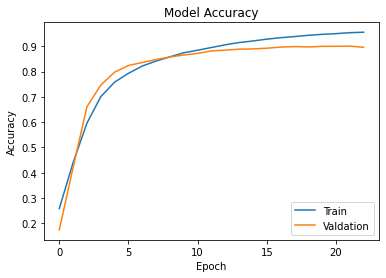

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valdation'], loc='lower right')
plt.show()

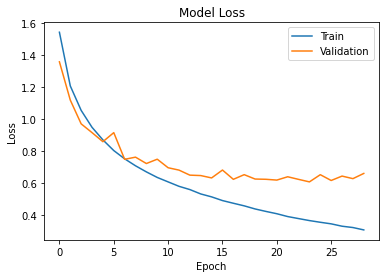

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Predict
Here we select 10 random pictures from our test set to test and visualize the accuracy of our model's predictions.

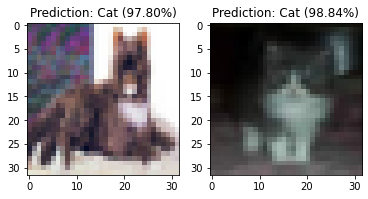

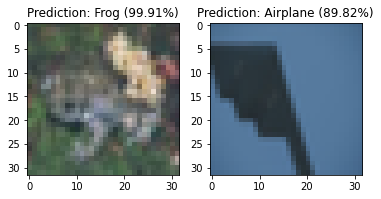

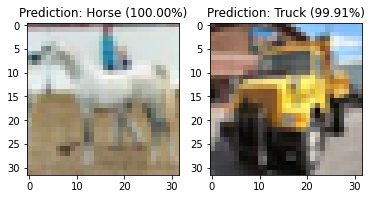

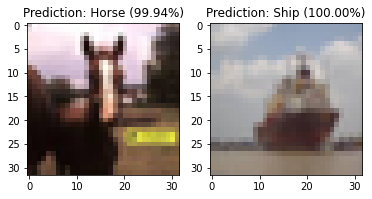

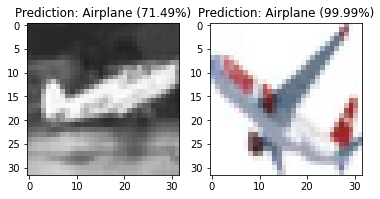

In [24]:
import random

images = []

for r in range(10):
  index = random.randint(0,1e4)
  image = X_test[index]
  label = labels[np.argmax(y_test[index])]
  prediction = model.predict(image.reshape(1,32,32,3))
  predicted_class = np.argmax(prediction)
  prediction = (labels[predicted_class],(prediction[0][predicted_class]*100))
  title = "Prediction: %s (%.2f%%)" % prediction
  images.append((image,title))

for i in range(0,10,2):
  display_images(images[i:i+2])

### Confusion Matrix

We can also draw a confusion matrix for our model using sklearn's builtin function.

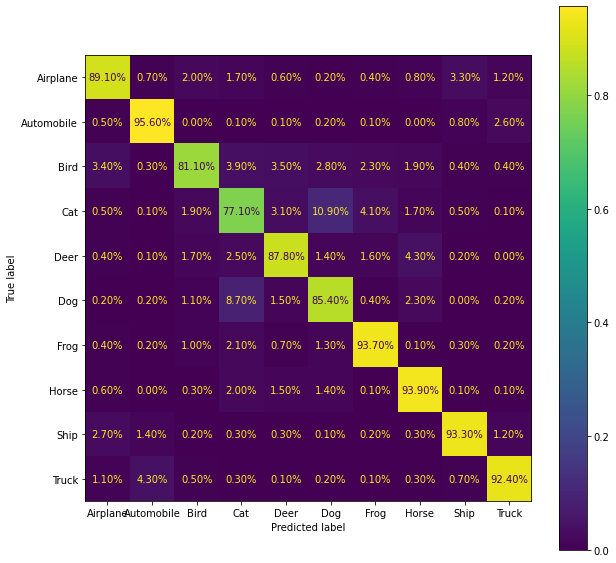

In [25]:
from sklearn.metrics import plot_confusion_matrix

y_pred = np.argmax(model.predict(X_test),axis=1)
y_test_cm = np.argmax(y_test,axis=1)

_, ax = plt.subplots(figsize=(10, 10))
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
cm = plot_confusion_matrix(IC, y_pred, y_test_cm, normalize='true', values_format='.2%',display_labels=labels, ax=ax);

### Test Any Image To See The Prediction
You can upload an image from your device to see what the model predicts it to be. (Please be gentle with your images (: )

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import cv2
from skimage.transform import resize

file_name = list(uploaded.keys())[0]
image_data = uploaded[file_name]
new_image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR) 
new_image = np.flip(new_image,2)
resized_image = resize(new_image, (32, 32, 3))
#predicting
prediction = model.predict(np.array([resized_image]))
prediction_index = np.argmax(prediction)
probablity = prediction[0][prediction_index]
plt.title("Prediction: %s (Probablity: %.2f%%)" % (labels[prediction_index],probablity*100))
img = plt.imshow(new_image)

### *UTILITY FUNCTIONS*

In [8]:
# Display Image
import matplotlib.pyplot as plt
%pylab inline
def display_image(img):
  imgplot = plt.imshow(img)
  plt.show()


def display_images(images):
  _, axs = plt.subplots(1,len(images))
  axs = axs.flatten()
  for img, ax in zip(images, axs):
    ax.set_title(img[1])
    if img[0].shape[2] == 1:
      ax.imshow(img[0].reshape(32,32), cmap="gray", vmin=0,vmax=255)
    else:
      ax.imshow(img[0])
  plt.show()

# Grayscale Converter
def grayscale_converter(x):
  # r * 0.21, g * 0.72, b * 0.07
  return (x[:,:,0]*0.21+x[:,:,1]*0.72+x[:,:,2]*0.07).reshape(32,32,1)

def grayscale_array(arr):
  return np.array(list(map(grayscale_converter, arr)))

# Flip Image
def flip_img(img):
  return np.flip(img,(1))

def flip_images_aug(x, y):
  new_x = np.array(list(map(flip_img, x)))
  return np.concatenate((x,new_x)),np.concatenate((y,y))



Populating the interactive namespace from numpy and matplotlib
